# MSM vs PGABM - BC Model observed positive
In this notebook we compare the performances of MSM and PGABM for a BC model with observed positive interactions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path += ["../src"]
import simulator_BC as sim_bc
import simulator_BC_evidences as sim_bc_e
import estimation_epsilon_BC as est_bc
import jax_estimation_BC as jest_bc
#import positive_edges_BC_estimation as pos_est
import calibration_observed_positive_BC as pos_cal
from calibrator_blackit import Calibrator #i just commented few lines of code to remove the output print
#from black_it.calibrator import Calibrator
import pandas as pd
from black_it.samplers.halton import HaltonSampler
import os
import contextlib
from scipy.special import expit as sigmoid
import torch
from itertools import product
import importlib
from time import time
import jax.numpy as jnp
import positive_edges_estimation_BC as pos_est

In [3]:
N = 200
T, edge_per_t = 1000, 4
rho = 70
mu = 0.2
epsilon = 0.11

In [4]:
X, edges = sim_bc_e.simulator_BC_evidence(N,T,edge_per_t,epsilon,mu)
X, edges = sim_bc.simulator_stoch(N,T,edge_per_t,epsilon,mu, steepness = 70)

### MSM

In [5]:
simulator_BC_pos = pos_cal.BC_observe_positive_simulator_given_previous_time(X, edges, mu, epsilon)

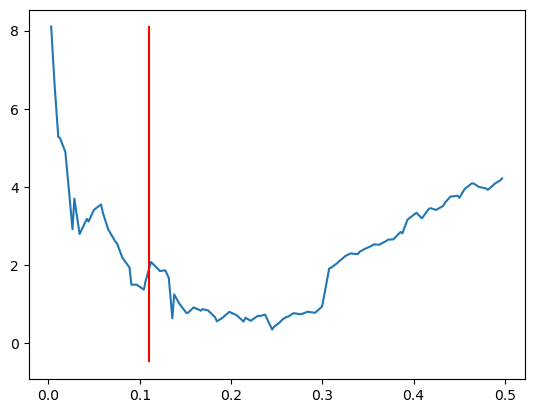

In [6]:
calibrate_epsilon = pos_cal.calibrate_epsilon_BC(simulator_BC_pos, plot_loss = True, calibration_batches = 100, 
                                                 sampler = HaltonSampler, batch_size = 1,
                                                 precisions = [0.0001], return_time = True)

In [7]:
epsilon_BCcal, loss_BCcal, time = calibrate_epsilon["epsilon"], calibrate_epsilon["loss"], calibrate_epsilon["time"]
#loss_epsilon_df = pd.DataFrame([{"epsilon": epsilon_BCcal[k,0], "loss": loss_BCcal[k]} for k in range(len(loss_BCcal))]).sort_values("epsilon").set_index("epsilon")

In [8]:
epsilon, epsilon_BCcal, time

(0.11, 0.2451, 23.22426962852478)

### PGABMs

In [ ]:
history_torch = pos_est.estimation_epsilon_torch(X, edges, mu, epsilon0 = 0.25, rho = 70,
                                                 num_epochs = 500, optimizer_name = "adam", 
                                                 lr = 0.01, hide_progress = False, sample_pairs = 20,
                                                 min_delta = 1e-4, patience = 40, return_time = True, min_epochs = 20)

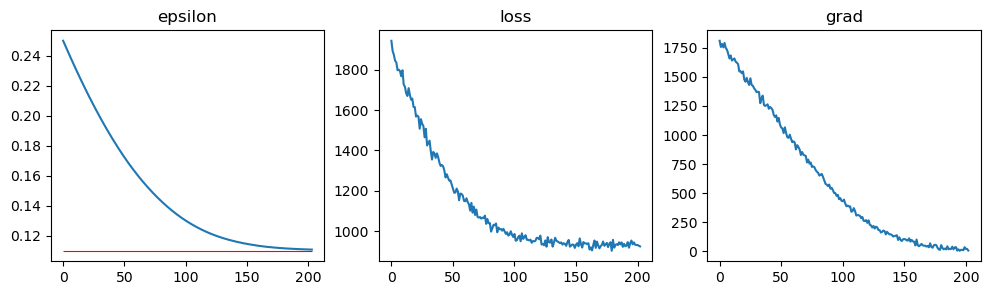

In [10]:
est_bc.print_history(history_torch, epsilon = epsilon)

## How to choose sample_pairs?
Too low values, can bring to errors with some particular trajectories.

In [392]:
N = 100
T = 2154
edge_per_t = 1
tot_edges = 4308.000000
epsilon = 0.332005
epsilon0 = 0.250000

In [234]:
for _ in range(100):
    X, edges = sim_bc.simulator_stoch(N, T, edge_per_t, epsilon, mu, steepness = 70)

    history = pos_est.estimation_epsilon_torch(X, edges, mu, epsilon0 = 0.25, rho = 70,
                                               num_epochs = 500, optimizer_name = "adam", 
                                               lr = 0.01, hide_progress = True, sample_pairs = 10,
                                               min_delta = 1e-4, patience = 50, return_time = True, min_epochs = 20)

    #est_bc.print_history(history, epsilon)

    print(_, "time", round(history["time"], 2), "distance", round(np.abs(history["epsilon"][-1] - epsilon), 3))
    
    if np.abs(history["epsilon"][-1] - epsilon) > 0.05:
        break

0 time 0.24 distance 0.005
1 time 0.26 distance 0.005
2 time 0.86 distance 0.043
3 time 0.3 distance 0.014
4 time 0.19 distance 0.035
5 time 0.31 distance 0.023
6 time 0.47 distance 0.011
7 time 0.78 distance 0.025
8 time 0.34 distance 0.014
9 time 0.86 distance 0.024
10 time 0.44 distance 0.022
11 time 0.28 distance 0.01
12 time 0.33 distance 0.005
13 time 0.61 distance 0.009
14 time 0.21 distance 0.012
15 time 0.28 distance 0.01
16 time 0.71 distance 0.039
17 time 0.65 distance 0.036
18 time 0.33 distance 0.012
19 time 0.22 distance 0.029
20 time 0.75 distance 0.038
21 time 0.36 distance 0.009
22 time 0.26 distance 0.011
23 time 0.21 distance 0.008
24 time 0.31 distance 0.015
25 time 0.7 distance 0.033
26 time 0.69 distance 0.021
27 time 0.2 distance 0.019
28 time 0.31 distance 0.016
29 time 0.21 distance 0.013
30 time 0.27 distance 0.013
31 time 0.23 distance 0.029
32 time 0.24 distance 0.016
33 time 0.31 distance 0.005
34 time 0.45 distance 0.016
35 time 0.26 distance 0.015
36 time

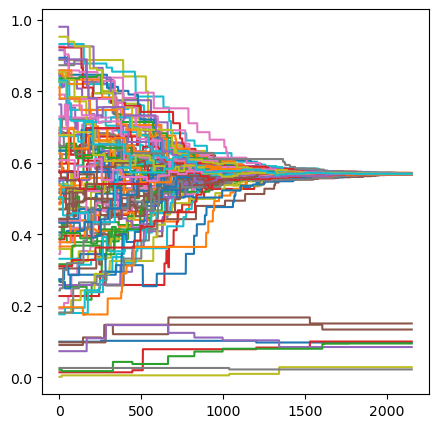

In [235]:
sim_bc.print_opinion_trajectory(X)

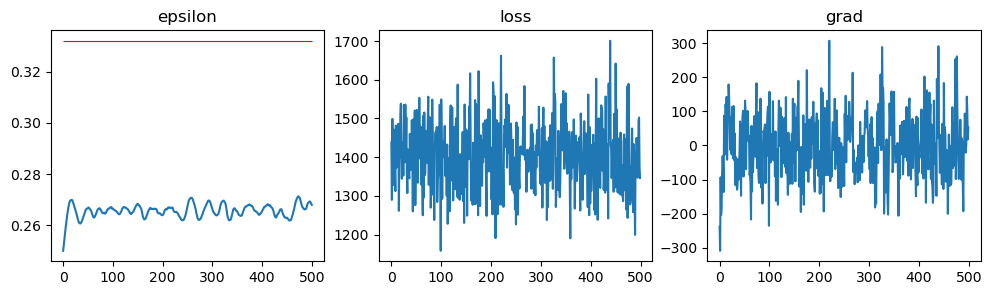

In [239]:
est_bc.print_history(history, epsilon)

So we choose sample_pairs = 100 (even if it is slower).

In [240]:
for _ in range(100):
    X, edges = sim_bc.simulator_stoch(N, T, edge_per_t, epsilon, mu, steepness = 70)

    history = pos_est.estimation_epsilon_torch(X, edges, mu, epsilon0 = 0.25, rho = 70,
                                               num_epochs = 500, optimizer_name = "adam", 
                                               lr = 0.01, hide_progress = True, sample_pairs = 50,
                                               min_delta = 1e-4, patience = 50, return_time = True, min_epochs = 20)


    print(_, "time", round(history["time"], 2), "distance", round(np.abs(history["epsilon"][-1] - epsilon), 3))
    
    if np.abs(history["epsilon"][-1] - epsilon) > 0.03:
        break

0 time 2.76 distance 0.006
1 time 2.61 distance 0.009
2 time 2.23 distance 0.009
3 time 1.24 distance 0.007
4 time 2.01 distance 0.004
5 time 2.3 distance 0.001
6 time 1.48 distance 0.001
7 time 2.13 distance 0.0
8 time 2.96 distance 0.001
9 time 2.06 distance 0.007
10 time 2.46 distance 0.006
11 time 1.85 distance 0.001
12 time 2.3 distance 0.011
13 time 2.56 distance 0.003
14 time 2.92 distance 0.005
15 time 2.83 distance 0.004
16 time 3.01 distance 0.005
17 time 2.44 distance 0.0
18 time 1.55 distance 0.0
19 time 1.4 distance 0.004
20 time 1.91 distance 0.0
21 time 0.9 distance 0.003
22 time 0.94 distance 0.001
23 time 1.3 distance 0.004
24 time 4.36 distance 0.007
25 time 1.94 distance 0.001
26 time 1.84 distance 0.006
27 time 2.46 distance 0.01
28 time 3.51 distance 0.004
29 time 2.67 distance 0.004
30 time 1.95 distance 0.002
31 time 2.48 distance 0.006
32 time 1.85 distance 0.006
33 time 1.67 distance 0.011
34 time 2.76 distance 0.003
35 time 1.91 distance 0.008
36 time 1.36 dis

## Complete comparison

In [13]:
def compare_msm_pgabm(N, T, edge_per_t, mu, epsilon, epsilon0, calibration_batches_list):
    
    output_data = {"N": N, "T": T, "edge_per_t": edge_per_t, "tot_edges": T * edge_per_t,
                       "epsilon": epsilon, "epsilon0": epsilon0, "mu": mu}
    
    X, edges = sim_bc.simulator_stoch(N, T, edge_per_t, epsilon, mu, rho)
    
    estimation_pgabm = pos_est.estimation_epsilon_torch(X, edges, mu, epsilon0 = 0.25, rho = 70,
                                                        num_epochs = 500, optimizer_name = "adam", 
                                                        lr = 0.01, hide_progress = True, sample_pairs = 20,
                                                        min_delta = 1e-4, patience = 50, return_time = True, min_epochs = 20)

    out_pgabm = {"epsilon_pgabm": estimation_pgabm["epsilon"][-1], "time_pgabm": estimation_pgabm["time"], 
                 "epochs_pgabm": len(estimation_pgabm["loss"]), "distance_epsilon_pgabm": np.abs(estimation_pgabm["epsilon"][-1] - epsilon)}
    
    
    simulator_BC_pos = pos_cal.BC_observe_positive_simulator_given_previous_time(X, edges, mu, epsilon)
    
    out_msm = {}
    for calibration_batches in calibration_batches_list:
        calibrate_epsilon = pos_cal.calibrate_epsilon_BC(simulator_BC_pos, plot_loss = False, calibration_batches = calibration_batches, 
                                                         sampler = HaltonSampler,
                                                         precisions = [0.0001], return_time = True)
        epsilon_BCcal, loss_BCcal, time_BCcal = calibrate_epsilon["epsilon"], calibrate_epsilon["loss"], calibrate_epsilon["time"] 
        
        out_msm = {**out_msm, f"epsilon_msm_{calibration_batches}_batches": epsilon_BCcal, 
                   f"time_msm_{calibration_batches}_batches": time_BCcal, 
                   f"distance_epsilon_msm_{calibration_batches}_batches": np.abs(epsilon_BCcal - epsilon)}

                
    
    return {**output_data, **out_pgabm, **out_msm}

def repeat_comparison_msm_pgabm(N_list, T_list, edge_per_t_list, calibration_batches_list,
                                        repetitions = 1):
    
    simulations_comparison = []
    
    tot_sim = len(N_list) * len(T_list) * len(edge_per_t_list) * repetitions
    
    print("Total simulations", tot_sim, "with ", len(calibration_batches_list), " batches")
    epsilons = np.random.random(size = tot_sim) / 2
    mus = np.random.random(size = tot_sim) 
    epsilon0 = 0.25
    
    sim = 0
    for _, edge_per_t, N, T in (product(np.arange(repetitions),
                                        edge_per_t_list,
                                        N_list, T_list)):
        epsilon = epsilons[sim]
        mu = mus[sim] * min(1, 2000 / (T * edge_per_t))
        
        sim += 1
        print("Simulation", sim, "N", N, "T", T, "edge_per_t", edge_per_t)
        
        comparison = compare_msm_pgabm(N, T, edge_per_t, mu, epsilon, epsilon0, calibration_batches_list)
        
        simulations_comparison.append(comparison)
            
    return pd.DataFrame(simulations_comparison)

In [1]:
"""repeated_comparisons = repeat_comparison_msm_pgabm(N_list = [int(u) for u in np.logspace(2, 4, num = 4)], 
                                                           T_list = [int(u) for u in np.logspace(2, 4, num = 4)], 
                                                           edge_per_t_list = [1,2,4],
                                                           calibration_batches_list = [20,50,100], 
                                                   repetitions = 5)"""

'repeated_comparisons = repeat_comparison_msm_pgabm(N_list = [int(u) for u in np.logspace(2, 4, num = 4)], \n                                                           T_list = [int(u) for u in np.logspace(2, 4, num = 4)], \n                                                           edge_per_t_list = [1,2,4],\n                                                           calibration_batches_list = [20,50,100], \n                                                   repetitions = 5)'

In [17]:
#repeated_comparisons.to_csv("../data/comparison_calibration_pgabm_positiveBC_230523.csv", index = 0)

#repeated_comparisons = pd.read_csv("../data/comparison_calibration_pgabm_positiveBC_230523.csv")

In [37]:
msm_simulations = pd.concat([repeated_comparisons[[f"time_msm_{batches}_batches", f"distance_epsilon_msm_{batches}_batches"]].rename(columns = {f"time_msm_{batches}_batches": "time", f"distance_epsilon_msm_{batches}_batches": "distance_epsilon"}).assign(batches = batches) for batches in ["20", "50", "100"]])



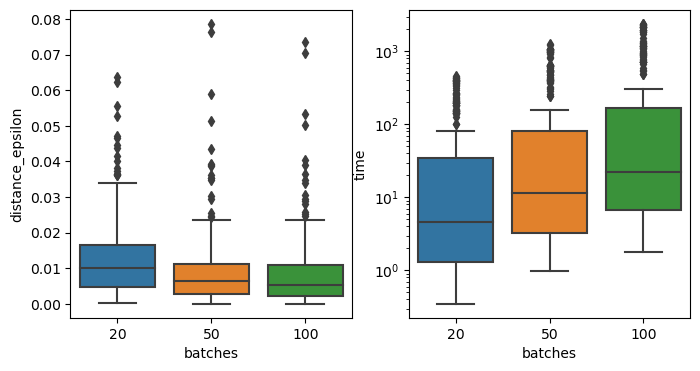

In [39]:
fig, axes = plt.subplots(ncols = 2, nrows = 1, figsize = [8,4])

sns.boxplot(data = msm_simulations, x = "batches", y = "distance_epsilon", ax = axes[0])
sns.boxplot(data = msm_simulations, x = "batches", y = "time", ax = axes[1])

axes[1].set_yscale("log")


In [62]:
repeated_comparisons.sort_values("time_pgabm")#.iloc[-1]

,N,T,edge_per_t,tot_edges,epsilon,epsilon0,mu,epsilon_pgabm,time_pgabm,epochs_pgabm,distance_epsilon_pgabm,epsilon_msm_20_batches,time_msm_20_batches,distance_epsilon_msm_20_batches,epsilon_msm_50_batches,time_msm_50_batches,distance_epsilon_msm_50_batches,epsilon_msm_100_batches,time_msm_100_batches,distance_epsilon_msm_100_batches
16,100,100,2,200,0.172368,0.25,0.819089,0.176222,0.092455,143,0.003853,0.1601,0.460311,0.012268,0.1557,1.140510,0.016668,0.1583,2.531293,0.014068
232,2154,100,4,400,0.309257,0.25,0.728851,0.309810,0.111169,129,0.000553,0.2838,1.148167,0.025457,0.3041,2.834039,0.005157,0.3051,3.673542,0.004157
13,10000,464,1,464,0.166032,0.25,0.812611,0.172298,0.157891,119,0.006266,0.1566,0.820433,0.009432,0.1604,2.265289,0.005632,0.1678,3.821522,0.001768
24,2154,100,2,200,0.399302,0.25,0.433592,0.403241,0.160709,196,0.003940,0.3910,0.465675,0.008302,0.4201,1.172071,0.020798,0.4188,2.390042,0.019498
4,464,100,1,100,0.086978,0.25,0.905809,0.097341,0.163482,225,0.010363,0.0956,0.393139,0.008622,0.0956,1.253861,0.008622,0.0956,2.728802,0.008622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,10000,2154,4,8616,0.255571,0.25,0.091712,0.255825,102.955642,500,0.000254,0.2460,22.065807,0.009571,0.2414,57.515973,0.014171,0.2454,120.769730,0.010171
82,100,2154,4,8616,0.259506,0.25,0.226404,0.264016,106.060129,500,0.004510,0.2622,24.261927,0.002694,0.2682,64.961514,0.008694,0.2658,131.643174,0.006294
107,2154,10000,1,10000,0.249792,0.25,0.062500,0.245894,113.745682,500,0.003898,0.2406,163.604182,0.009192,0.2483,413.529167,0.001492,0.2480,834.184462,0.001792
210,100,2154,2,4308,0.412005,0.25,0.365421,0.308801,117.703499,500,0.103204,0.4337,13.766282,0.021695,0.4285,34.148166,0.016495,0.4285,65.028371,0.016495


-0.0012028085688400303


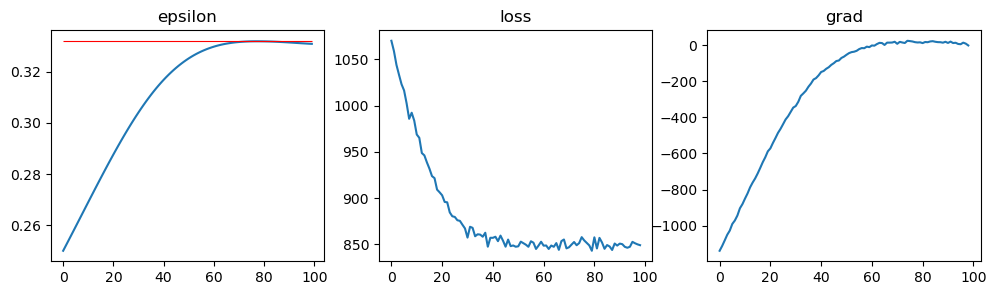

In [229]:
history1 = pos_est.estimation_epsilon_torch(X, edges, mu, epsilon0 = 0.25, rho = 70,
                                            num_epochs = 5000, optimizer_name = "adam", 
                                            lr = 0.01, hide_progress = True, sample_pairs = 100,
                                            min_delta = 1e-4, patience = 30, return_time = True, min_epochs = 20)


est_bc.print_history(history1, epsilon)
print(history1["epsilon"][-1] - epsilon)

In [198]:
uvst = sim_bc.convert_edges_uvst(edges)
u,v,s,t = positive_edges = uvst[:, uvst[2,:] == 1]

diff_X_positive = torch.abs(X[t,u] - X[t,v])

n_negative_interactions = edge_per_t - edges.sum(axis = 1)[:,2]

In [166]:
diff_X_positive

tensor([0.2178, 0.2309, 0.2551,  ..., 0.0010, 0.0009, 0.0018],
       dtype=torch.float64)

In [167]:
log_likelihood_observed = torch.sum(torch.log(torch.sigmoid(rho * (epsilon - diff_X_positive))))

In [182]:
sample_pairs = 100

In [183]:
u_sample, v_sample = torch.randint(N, (T, sample_pairs, 2)).T
abs_diff_sample_X = torch.abs(torch.gather(X, 1, u_sample.T) - torch.gather(X, 1, v_sample.T))
kappa_neg = torch.sigmoid(-rho * (epsilon - abs_diff_sample_X))[:-1]
#n_negative_interactions = edge_per_t - edges.sum(axis = 1)[:,2]

log_likelihood_non_observed = torch.sum(torch.log(kappa_neg.mean(axis = 1)) * n_negative_interactions)


neg_tot_log_likelihood = - log_likelihood_observed - log_likelihood_non_observed
    

In [194]:
epsilon, mu

(0.332005, 0.2)

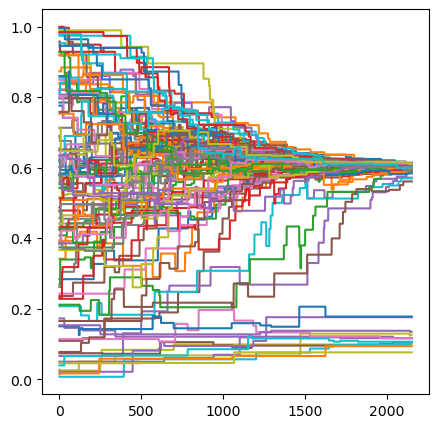

In [199]:
sim_bc.print_opinion_trajectory(X)

In [110]:
repeated_comparisons_only_msm = repeated_comparisons[['N', 'T', 'edge_per_t', 'tot_edges', 'epsilon', 'epsilon0', 'mu',
                                                      'epsilon_msm_20_batches', 'time_msm_20_batches',
                                                      'distance_epsilon_msm_20_batches', 'epsilon_msm_50_batches',
                                                      'time_msm_50_batches', 'distance_epsilon_msm_50_batches',
                                                      'epsilon_msm_100_batches', 'time_msm_100_batches',
                                                      'distance_epsilon_msm_100_batches']]

In [111]:
repeated_comparisons_only_msm.to_csv("../data/simulation_positiveBC_only_msm_240523.csv", index = 0)



In [388]:
def repeat_simulations_pgabms(N_list, T_list, edge_per_t_list,repetitions = 1, sample_pairs = 50, rho = rho):
    simulations = []
    
    tot_sim = len(N_list) * len(T_list) * len(edge_per_t_list) * repetitions
    
    print("Total simulations", tot_sim)
    epsilons = np.random.random(size = tot_sim) / 2
    mus = np.random.random(size = tot_sim) 
    epsilon0 = 0.25
    
    sim = 0
    for _, edge_per_t, N, T in (product(np.arange(repetitions),
                                        edge_per_t_list,
                                        N_list, T_list)):
        epsilon = epsilons[sim]
        mu = mus[sim] * min(1, 2000 / (T * edge_per_t))
        
        sim += 1
        print("Simulation", sim, "N", N, "T", T, "edge_per_t", edge_per_t)
        
        X, edges = sim_bc.simulator_stoch(N, T, edge_per_t, epsilon, mu, rho)
        estimation_pgabm = pos_est.estimation_epsilon_torch(X, edges, mu, epsilon0 = 0.25, rho = rho,
                                                        num_epochs = 500, optimizer_name = "adam", 
                                                        lr = 0.01, hide_progress = True, sample_pairs = sample_pairs,
                                                        min_delta = 1e-4, patience = 50, return_time = True, min_epochs = 20)

        
        output_data = {"N": N, "T": T, "edge_per_t": edge_per_t, "tot_edges": T * edge_per_t,
                       "epsilon": epsilon, "epsilon0": epsilon0, "mu": mu}
    
        out_pgabm = {"epsilon_pgabm": estimation_pgabm["epsilon"][-1], "time_pgabm": estimation_pgabm["time"], 
                 "epochs_pgabm": len(estimation_pgabm["loss"]), "distance_epsilon_pgabm": np.abs(estimation_pgabm["epsilon"][-1] - epsilon)}
        
        simulations.append({**output_data, **out_pgabm})
            
    return pd.DataFrame(simulations)


In [246]:
repeated_comparisons_only_pgabm = repeat_simulations_pgabms(N_list = [int(u) for u in np.logspace(2, 4, num = 4)], 
                                                              T_list = [int(u) for u in np.logspace(2, 4, num = 4)], 
                                                              edge_per_t_list = [1,2,4],
                                                              repetitions = 5)

#repeated_comparisons_only_pgabm.to_csv("../data/simulation_positiveBC_only_pgabm_240523.csv", index = 0)


In [265]:
repeated_comparisons_only_msm_stack = pd.concat([repeated_comparisons_only_msm.set_index(["N", "T", "edge_per_t", "tot_edges", 
                                                    "epsilon", "epsilon0", "mu"])\
                                                 [[f"epsilon_msm_{batches}_batches",
                                                   f"time_msm_{batches}_batches",
                                                   f"distance_epsilon_msm_{batches}_batches"]]
                                                 .rename(columns = {f"epsilon_msm_{batches}_batches": "epsilon_estimated", 
                                                                    f"time_msm_{batches}_batches": "time", 
                                                                    f"distance_epsilon_msm_{batches}_batches": "distance_epsilon"})\
                                                 .assign(method = f"msm_{batches}_batches") for batches in ["20", "50", "100"]]).reset_index()

#repeated_comparisons_only_msm_stack.to_csv("../data/simulation_positiveBC_only_pgabm_stack_240523.csv", index = 0)


In [286]:
full_comparison_stack = pd.concat([repeated_comparisons_only_pgabm.rename(columns = {"epsilon_pgabm": "epsilon_estimated",
                                                                                     "time_pgabm": "time", 
                                                                                     "distance_epsilon_pgabm": "distance_epsilon"}).assign(method = "pgabm"),
                                   repeated_comparisons_only_msm_stack])



#full_comparison_stack.to_csv("../data/full_comparison_stack_positiveBC_240523.csv", index = 0)


In [272]:
full_comparison_stack.groupby("method").mean()[["distance_epsilon", "time"]]

,distance_epsilon,time
method,,
msm_100_batches,0.008691,329.237656
msm_20_batches,0.012990,63.960083
msm_50_batches,0.009661,164.865587
pgabm,0.005246,2.918450


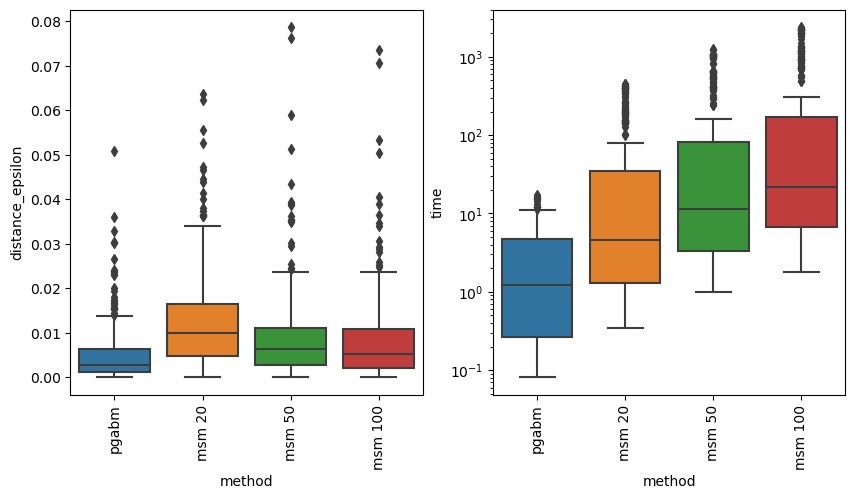

In [285]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = [10, 5])

sns.boxplot(data = full_comparison_stack, x = "method", y = "distance_epsilon", ax = axes[0])
sns.boxplot(data = full_comparison_stack,  x = "method", y = "time", ax = axes[1])

axes[0].set_xticks(np.arange(4), ["pgabm", "msm 20","msm 50","msm 100",], rotation=90)
axes[1].set_xticks(np.arange(4), ["pgabm", "msm 20","msm 50","msm 100",], rotation=90)

axes[1].set_yscale("log")

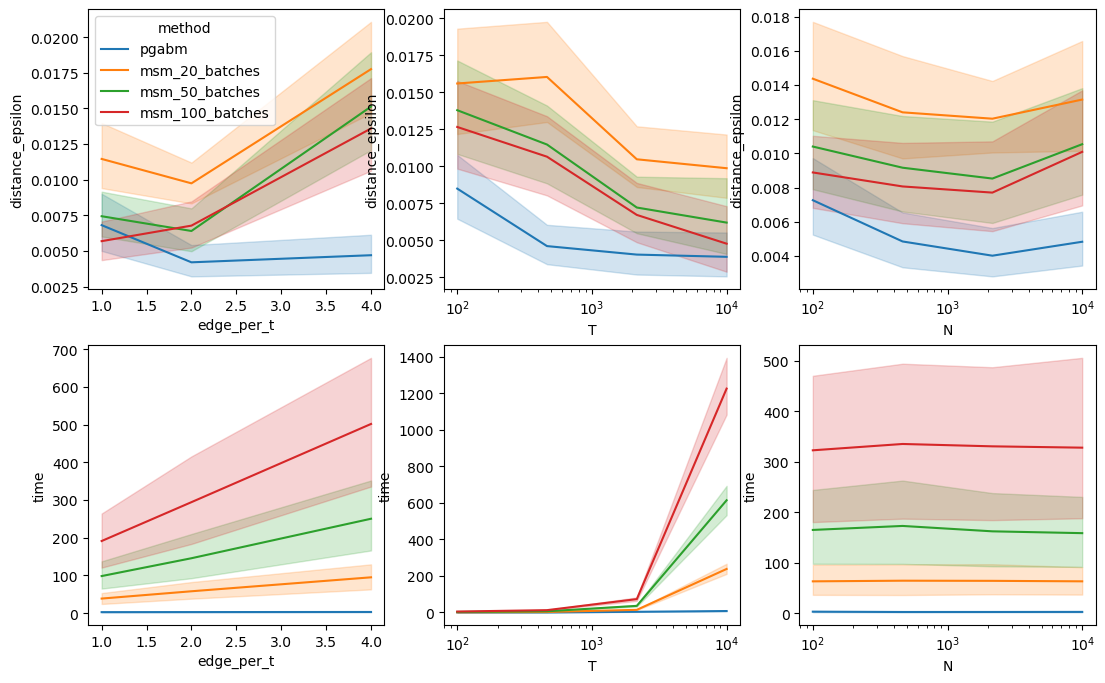

In [412]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = [13, 8])

sns.lineplot(data = full_comparison_stack.reset_index(), hue = "method", x = "edge_per_t", y = "distance_epsilon", ax = axes[0,0])
sns.lineplot(data = full_comparison_stack.reset_index(), hue = "method", x = "T", y = "distance_epsilon", ax = axes[0,1])
sns.lineplot(data = full_comparison_stack.reset_index(), hue = "method", x = "N", y = "distance_epsilon", ax = axes[0,2])

sns.lineplot(data = full_comparison_stack.reset_index(), hue = "method",  x = "edge_per_t", y = "time", ax = axes[1,0])
sns.lineplot(data = full_comparison_stack.reset_index(), hue = "method", x = "T", y = "time", ax = axes[1,1])
sns.lineplot(data = full_comparison_stack.reset_index(), hue = "method",  x = "N", y = "time", ax = axes[1,2])


axes[0,1].set_xscale("log")
axes[1,1].set_xscale("log")
axes[0,2].set_xscale("log")
axes[1,2].set_xscale("log")

#axes[1,0].set_yscale("log")
#axes[1,1].set_yscale("log")

axes[1,0].get_legend().remove()
axes[0,1].get_legend().remove()
axes[1,1].get_legend().remove()
axes[0,2].get_legend().remove()
axes[1,2].get_legend().remove()



### Increasing edge_per_t

In [421]:
repeated_comparisons = repeat_comparison_msm_pgabm(N_list = [int(u) for u in np.logspace(2, 3, num = 3)],
                                                           T_list = [int(u) for u in np.logspace(2, 3, num = 3)],
                                                           edge_per_t_list = [1,2,4,8,16,32],
                                                           calibration_batches_list = [20,50,100], 
                                                   repetitions = 4)

Total simulations 216 with  3  batches
Simulation 1 N 100 T 100 edge_per_t 1
Simulation 2 N 100 T 316 edge_per_t 1
Simulation 3 N 100 T 1000 edge_per_t 1
Simulation 4 N 316 T 100 edge_per_t 1
Simulation 5 N 316 T 316 edge_per_t 1
Simulation 6 N 316 T 1000 edge_per_t 1
Simulation 7 N 1000 T 100 edge_per_t 1
Simulation 8 N 1000 T 316 edge_per_t 1
Simulation 9 N 1000 T 1000 edge_per_t 1
Simulation 10 N 100 T 100 edge_per_t 2
Simulation 11 N 100 T 316 edge_per_t 2
Simulation 12 N 100 T 1000 edge_per_t 2
Simulation 13 N 316 T 100 edge_per_t 2
Simulation 14 N 316 T 316 edge_per_t 2
Simulation 15 N 316 T 1000 edge_per_t 2
Simulation 16 N 1000 T 100 edge_per_t 2
Simulation 17 N 1000 T 316 edge_per_t 2
Simulation 18 N 1000 T 1000 edge_per_t 2
Simulation 19 N 100 T 100 edge_per_t 4
Simulation 20 N 100 T 316 edge_per_t 4
Simulation 21 N 100 T 1000 edge_per_t 4
Simulation 22 N 316 T 100 edge_per_t 4
Simulation 23 N 316 T 316 edge_per_t 4
Simulation 24 N 316 T 1000 edge_per_t 4
Simulation 25 N 1000

Simulation 173 N 100 T 316 edge_per_t 2
Simulation 174 N 100 T 1000 edge_per_t 2
Simulation 175 N 316 T 100 edge_per_t 2
Simulation 176 N 316 T 316 edge_per_t 2
Simulation 177 N 316 T 1000 edge_per_t 2
Simulation 178 N 1000 T 100 edge_per_t 2
Simulation 179 N 1000 T 316 edge_per_t 2
Simulation 180 N 1000 T 1000 edge_per_t 2
Simulation 181 N 100 T 100 edge_per_t 4
Simulation 182 N 100 T 316 edge_per_t 4
Simulation 183 N 100 T 1000 edge_per_t 4
Simulation 184 N 316 T 100 edge_per_t 4
Simulation 185 N 316 T 316 edge_per_t 4
Simulation 186 N 316 T 1000 edge_per_t 4
Simulation 187 N 1000 T 100 edge_per_t 4
Simulation 188 N 1000 T 316 edge_per_t 4
Simulation 189 N 1000 T 1000 edge_per_t 4
Simulation 190 N 100 T 100 edge_per_t 8
Simulation 191 N 100 T 316 edge_per_t 8
Simulation 192 N 100 T 1000 edge_per_t 8
Simulation 193 N 316 T 100 edge_per_t 8
Simulation 194 N 316 T 316 edge_per_t 8
Simulation 195 N 316 T 1000 edge_per_t 8
Simulation 196 N 1000 T 100 edge_per_t 8
Simulation 197 N 1000 T 3

In [422]:
repeated_comparisons.to_csv("../data/simulation_positiveBC_edge_per_t_250523.csv", index = 0)


In [423]:
repeated_comparisons

,N,T,edge_per_t,tot_edges,epsilon,epsilon0,mu,epsilon_pgabm,time_pgabm,epochs_pgabm,distance_epsilon_pgabm,epsilon_msm_20_batches,time_msm_20_batches,distance_epsilon_msm_20_batches,epsilon_msm_50_batches,time_msm_50_batches,distance_epsilon_msm_50_batches,epsilon_msm_100_batches,time_msm_100_batches,distance_epsilon_msm_100_batches
0,100,100,1,100,0.410101,0.25,0.377217,0.402649,0.096627,180,0.007452,0.4378,0.250421,0.027699,0.4194,0.627424,0.009299,0.4206,1.237272,0.010499
1,100,316,1,316,0.249671,0.25,0.424437,0.234784,0.306292,500,0.014887,0.2503,0.397827,0.000629,0.2552,0.996157,0.005529,0.2561,2.004347,0.006429
2,100,1000,1,1000,0.018792,0.25,0.472965,0.037028,0.386656,411,0.018236,0.0256,1.038168,0.006808,0.0241,2.592979,0.005308,0.0253,5.174679,0.006508
3,316,100,1,100,0.073751,0.25,0.422842,0.079990,0.132313,265,0.006239,0.0679,0.255203,0.005851,0.0905,0.618183,0.016749,0.0862,1.237704,0.012449
4,316,316,1,316,0.461319,0.25,0.102757,0.465842,0.170435,269,0.004522,0.4371,0.399433,0.024219,0.4420,1.000843,0.019319,0.4473,1.992920,0.014019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,316,316,32,10112,0.016379,0.25,0.168959,0.037337,0.264035,408,0.020958,0.0326,4.340693,0.016221,0.0344,10.562922,0.018021,0.0351,21.159529,0.018721
212,316,1000,32,32000,0.338178,0.25,0.046412,0.335207,0.152938,124,0.002971,0.3280,18.620137,0.010178,0.3438,46.066929,0.005622,0.3429,92.830036,0.004722
213,1000,100,32,3200,0.115852,0.25,0.454438,0.113317,0.103025,198,0.002535,0.3404,1.188507,0.224548,0.1276,2.981724,0.011748,0.1263,6.484206,0.010448
214,1000,316,32,10112,0.206796,0.25,0.169856,0.207671,0.093325,135,0.000875,0.2212,4.355847,0.014404,0.1860,10.627272,0.020796,0.1852,21.250899,0.021596


In [429]:
repeated_comparisons_edge_per_t_stack = pd.concat([repeated_comparisons.set_index(["N", "T", "edge_per_t", "tot_edges",
                                                                                   "epsilon", "epsilon0", "mu"])\
                                                   [[f"epsilon_msm_{batches}_batches",
                                                     f"time_msm_{batches}_batches",
                                                     f"distance_epsilon_msm_{batches}_batches"]]
                                                   .rename(columns = {f"epsilon_msm_{batches}_batches": "epsilon_estimated", 
                                                                      f"time_msm_{batches}_batches": "time", 
                                                                      f"distance_epsilon_msm_{batches}_batches": "distance_epsilon"})\
                                                   .assign(method = f"msm_{batches}_batches") for batches in ["20", "50", "100"]]).reset_index()
repeated_comparisons_edge_per_t_stack = pd.concat([repeated_comparisons_edge_per_t_stack,
                                                   repeated_comparisons.set_index(["N", "T", "edge_per_t", "tot_edges",
                                                                                   "epsilon", "epsilon0", "mu"])\
                                                   [["epsilon_pgabm", "time_pgabm", "distance_epsilon_pgabm"]]\
                                                   .rename(columns = {f"epsilon_pgabm": "epsilon_estimated", 
                                                                      f"time_pgabm": "time", 
                                                                      f"distance_epsilon_pgabm": "distance_epsilon"})\
                                                   .assign(method = "pgabm").reset_index()
                                                  ])

In [430]:
repeated_comparisons_edge_per_t_stack

,N,T,edge_per_t,tot_edges,epsilon,epsilon0,mu,epsilon_estimated,time,distance_epsilon,method
0,100,100,1,100,0.410101,0.25,0.377217,0.437800,0.250421,0.027699,msm_20_batches
1,100,316,1,316,0.249671,0.25,0.424437,0.250300,0.397827,0.000629,msm_20_batches
2,100,1000,1,1000,0.018792,0.25,0.472965,0.025600,1.038168,0.006808,msm_20_batches
3,316,100,1,100,0.073751,0.25,0.422842,0.067900,0.255203,0.005851,msm_20_batches
4,316,316,1,316,0.461319,0.25,0.102757,0.437100,0.399433,0.024219,msm_20_batches
...,...,...,...,...,...,...,...,...,...,...,...
211,316,316,32,10112,0.016379,0.25,0.168959,0.037337,0.264035,0.020958,pgabm
212,316,1000,32,32000,0.338178,0.25,0.046412,0.335207,0.152938,0.002971,pgabm
213,1000,100,32,3200,0.115852,0.25,0.454438,0.113317,0.103025,0.002535,pgabm
214,1000,316,32,10112,0.206796,0.25,0.169856,0.207671,0.093325,0.000875,pgabm


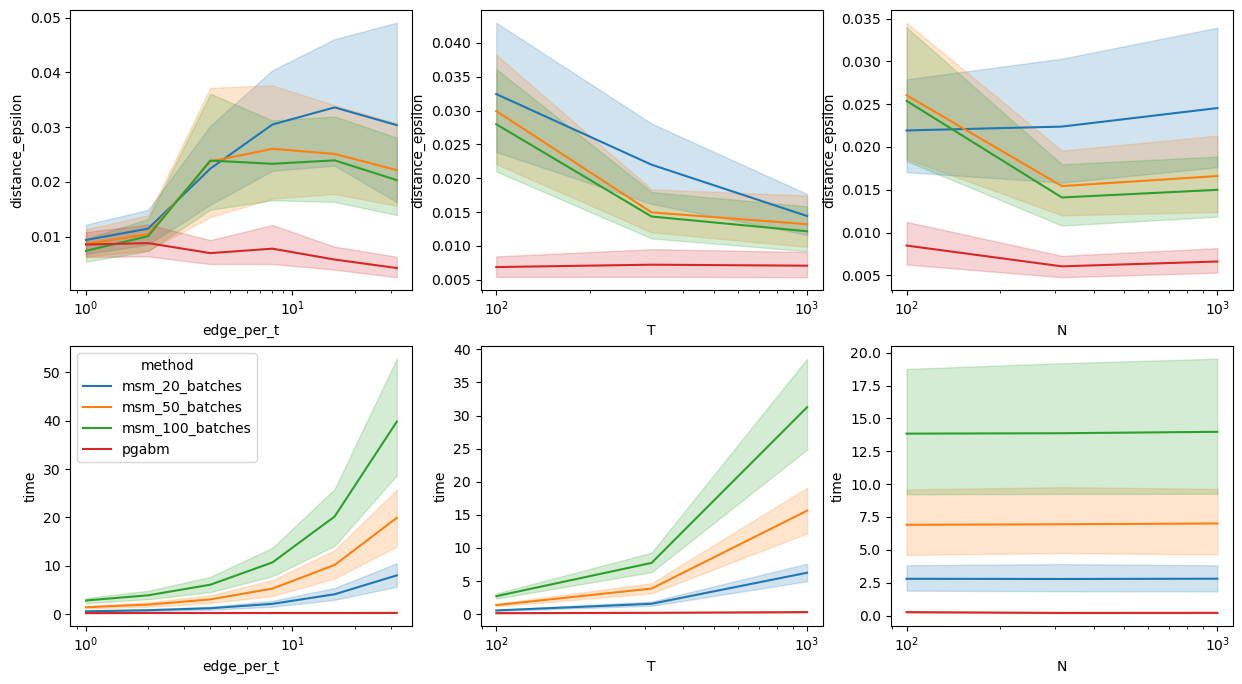

In [434]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = [15, 8])

sns.lineplot(data = repeated_comparisons_edge_per_t_stack.reset_index(), hue = "method", x = "edge_per_t", y = "distance_epsilon", ax = axes[0,0])
sns.lineplot(data = repeated_comparisons_edge_per_t_stack.reset_index(), hue = "method", x = "T", y = "distance_epsilon", ax = axes[0,1])
sns.lineplot(data = repeated_comparisons_edge_per_t_stack.reset_index(), hue = "method", x = "N", y = "distance_epsilon", ax = axes[0,2])

sns.lineplot(data = repeated_comparisons_edge_per_t_stack.reset_index(), hue = "method",  x = "edge_per_t", y = "time", ax = axes[1,0])
sns.lineplot(data = repeated_comparisons_edge_per_t_stack.reset_index(), hue = "method", x = "T", y = "time", ax = axes[1,1])
sns.lineplot(data = repeated_comparisons_edge_per_t_stack.reset_index(), hue = "method",  x = "N", y = "time", ax = axes[1,2])


axes[0,0].set_xscale("log")
axes[1,0].set_xscale("log")
axes[0,1].set_xscale("log")
axes[1,1].set_xscale("log")
axes[0,2].set_xscale("log")
axes[1,2].set_xscale("log")

#axes[1,0].set_yscale("log")
#axes[1,1].set_yscale("log")

axes[0,0].get_legend().remove()
axes[0,1].get_legend().remove()
axes[1,1].get_legend().remove()
axes[0,2].get_legend().remove()
axes[1,2].get_legend().remove()